#**Image Forgery Detection**


In [ ]:
!pip install opendatasets --upgrade --quiet

##**Downlaoding the dataset**

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/divg07/casia-20-image-tampering-detection-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aryanbansal2000
Your Kaggle Key: ··········


  0%|          | 0.00/2.56G [00:00<?, ?B/s]

100%|██████████| 2.56G/2.56G [00:37<00:00, 73.1MB/s]


In [ ]:
import os

DATA_DIR = './casia-20-image-tampering-detection-dataset/CASIA2'
print(os.listdir(DATA_DIR))

['Tp', 'CASIA 2 Groundtruth', 'Au']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

##**Importing Necessary Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import model_from_json
from PIL import Image, ImageChops, ImageEnhance
import PIL
import os
import itertools
from tqdm import tqdm
tf.__version__

'2.4.1'

##**Error Level Analysis**

In [ ]:
def ELA(img_path, quality=90):
    TEMP = 'ela_' + 'temp.jpg'
    SCALE = 10
    original = Image.open(img_path)
    diff=""
    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
        
    except:
        
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)
        
       
    d=diff.load()
    WIDTH, HEIGHT = diff.size
    for x in range(WIDTH):
        for y in range(HEIGHT):
            d[x, y] = tuple(k * SCALE for k in d[x, y])
#     save_path = dataset_path +'ELA_IMAGES/'
#     diff.save(save_path+'diff.png')
    return diff

In [ ]:
dataset_path="./casia-20-image-tampering-detection-dataset/CASIA2/"
path_original = 'Au/'
path_tampered = 'Tp/'
# path_mask='CASIA 2 Groundtruth/'
total_original = os.listdir(dataset_path+path_original)
total_tampered = os.listdir(dataset_path+path_tampered)
# total_mask=os.listdir(dataset_path+path_mask)

In [ ]:
pristine_images = []
for i in total_original:
    pristine_images.append(dataset_path+path_original+i)
fake_images = []
for i in total_tampered:
    fake_images.append(dataset_path+path_tampered+i)

In [ ]:
len(total_tampered),len(fake_images)

(5125, 5125)

In [ ]:
image_size = (224,224)
output_path='./'

In [ ]:
output_path='./'
if not os.path.exists(output_path+"resized_images/"):
#     os.makedirs(output_path+"resized_images/fake_masks/")
    os.makedirs(output_path+"resized_images/fake_images/")
    os.makedirs(output_path+"resized_images/pristine_images/")
    height = 224
    width = 224
#     p2=output_path+"resized_images/fake_masks/"
    p1=output_path+"resized_images/fake_images/"
    p3=output_path+"resized_images/pristine_images/"
    j=0
    for fake_image in tqdm(total_tampered):
        try:
            if(j%3):
                j+=1
                continue
            img=Image.open(dataset_path+path_tampered + fake_image).convert("RGB")
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(p1+fake_image)
            j+=1
        except:
            print("Encountered Invalid File : ",fake_image)
        
    j=0
    for pristine_image in tqdm(total_original):
        try:
            if(j%3):
                j+=1
                continue
            img=Image.open(dataset_path+path_original + pristine_image).convert("RGB")
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(p3+pristine_image)
            j+=1
        except:
            print("Invalid File : " ,pristine_image)
        
        
        
else:
    print('images resized,path exists')

  2%|▏         | 169/7492 [00:00<00:17, 407.61it/s]/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)
 64%|██████▍   | 4810/7492 [00:10<00:06, 393.13it/s]

Invalid File :  Thumbs.db


100%|██████████| 7492/7492 [00:16<00:00, 441.77it/s]


In [ ]:
resized_fake_image_path=output_path+"resized_images/fake_images/"
resized_pristine_image_path=output_path+"resized_images/pristine_images/"
resized_fake_image=os.listdir(resized_fake_image_path)
resized_pristine_image=os.listdir(resized_pristine_image_path)

In [ ]:
len(resized_pristine_image)

2497

In [ ]:
ela_images_path=output_path+'ELA_IMAGES/'
ela_real=ela_images_path+'Au/'
ela_fake=ela_images_path+'Tp/'
if not os.path.exists(ela_images_path):
    os.makedirs(ela_images_path)
    os.mkdir(ela_real)
    os.mkdir(ela_fake)
    j=0
    for i in tqdm(resized_fake_image):
        ELA(resized_fake_image_path+i).save(ela_fake+i)
        j+=1
        if(j==1500):
            break
    j=0
    for i in tqdm(resized_pristine_image):
        ELA(resized_pristine_image_path+i).save(ela_real+i)
        j+=1
        if(j==1500):
            break
else:
    print('Images are already converted to ELA')

 60%|█████▉    | 1498/2497 [01:27<01:00, 16.40it/s]

In [ ]:
X=[]
Y=[]
j=0
for file in tqdm(os.listdir(ela_real)):
    img=Image.open(ela_real+file)
    img=np.array(img)
    X.append(img)
    Y.append(0)
    j+=1
    if(j==1500):
        break
j=0
for file in tqdm(os.listdir(ela_fake)):
    img=Image.open(ela_fake+file)
    img=np.array(img)
    X.append(img)
    Y.append(1)
    j+=1
    if(j==1500):
        break



  0%|          | 0/1500 [00:00<?, ?it/s]

  7%|▋         | 102/1500 [00:00<00:01, 1011.18it/s]

 13%|█▎        | 195/1500 [00:00<00:01, 984.45it/s] 

 19%|█▉        | 292/1500 [00:00<00:01, 977.76it/s]

 26%|██▌       | 385/1500 [00:00<00:01, 961.42it/s]

 32%|███▏      | 478/1500 [00:00<00:01, 951.32it/s]

 38%|███▊      | 574/1500 [00:00<00:00, 951.70it/s]

 45%|████▍     | 672/1500 [00:00<00:00, 957.30it/s]

 51%|█████     | 765/1500 [00:00<00:00, 947.72it/s]

 57%|█████▋    | 860/1500 [00:00<00:00, 946.09it/s]

 64%|██████▎   | 956/1500 [00:01<00:00, 948.25it/s]

 70%|███████   | 1052/1500 [00:01<00:00, 948.84it/s]

 77%|███████▋  | 1152/1500 [00:01<00:00, 960.94it/s]

 83%|████████▎ | 1247/1500 [00:01<00:00, 953.78it/s]

 89%|████████▉ | 1342/1500 [00:01<00:00, 948.73it/s]

 96%|█████████▌| 1439/1500 [00:01<00:00, 913.17it/s]


  0%|          | 0/1500 [00:00<?, ?it/s]

  9%|▊         | 129/1500 [00:00<00:01, 1285.70it/s]

 17%|█▋        | 260/1500 [00:00<00:00, 1289.68it/s]

 26

In [ ]:
X=np.array(X)
X.shape

(3000, 224, 224, 3)

##**Test-Train Split**

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

x_train, x_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.2, random_state=133,shuffle=True)
y_train=to_categorical(y_train,2)
y_dev=to_categorical(y_dev,2)

#**MobileNetV2**

In [ ]:
from tensorflow.keras.applications import MobileNetV2,VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization,Dropout,MaxPooling2D
from tensorflow.keras.regularizers import l1,l2,l1_l2

base_model = MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
x=Conv2D(1024,(3,3),padding='same',activation='relu')(x)
x=GlobalAveragePooling2D()(x)
x=Flatten()(x)
x=Dense(1024,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x=Dropout(0.3)(x)
x=Dense(16,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x=Dense(2,activation='softmax')(x)
model=Model(base_model.input,x)


9412608/9406464 [==============================] - 0s 0us/step


##**Model Summary**

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
epochs = 100
batch_size = 20

##**Early Stopping**

In [ ]:
import keras

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=13,verbose=1,restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.22, patience = 6, verbose = 1, 
                                              min_delta = 0.0001,min_lr=0.0001)

In [ ]:
hist = model.fit(x_train,y_train,
                 epochs = epochs,
                validation_data = (x_dev,y_dev),
                callbacks = [early_stop,reduce_lr],
                verbose=1,shuffle=True)

Epoch 1/100



 60%|█████▉    | 1498/2497 [01:40<01:00, 16.40it/s]

75/75 [==============================] - 42s 90ms/step - loss: 7.5772 - accuracy: 0.7366 - val_loss: 2.4766 - val_accuracy: 0.7917
Epoch 2/100
75/75 [==============================] - 5s 67ms/step - loss: 2.1271 - accuracy: 0.7679 - val_loss: 1.4094 - val_accuracy: 0.7900
Epoch 3/100
75/75 [==============================] - 5s 67ms/step - loss: 1.2488 - accuracy: 0.7995 - val_loss: 0.8546 - val_accuracy: 0.7900
Epoch 4/100
75/75 [==============================] - 5s 67ms/step - loss: 0.7851 - accuracy: 0.7950 - val_loss: 0.6617 - val_accuracy: 0.7917
Epoch 5/100
75/75 [==============================] - 5s 67ms/step - loss: 0.6415 - accuracy: 0.7921 - val_loss: 0.5699 - val_accuracy: 0.7950
Epoch 6/100
75/75 [==============================] - 5s 67ms/step - loss: 0.5897 - accuracy: 0.7872 - val_loss: 0.5346 - val_accuracy: 0.7950
Epoch 7/100
75/75 [==============================] - 5s 67ms/step - loss: 0.5099 - accuracy: 0.8053 - val_loss: 0.5239 - val_accuracy: 0.7933
Epoch 8/100
75/75

##**Loss and accuracy plots for training and validation**

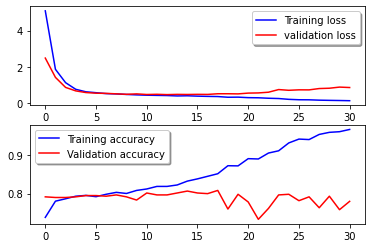

In [ ]:
 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

##**XGBoost for Classification**

In [ ]:
feature_extractor=base_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF

#RANDOM FOREST
#from sklearn.ensemble import RandomForestClassifier
#model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
y_train_label=np.where(y_train==1)[1]

#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train_label) #For sklearn no one hot encoding

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Accuracy =  0.8033333333333333


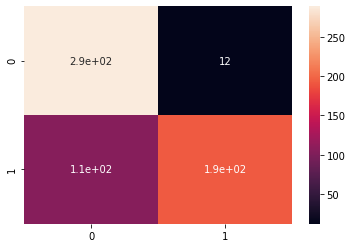

In [ ]:
import seaborn as sns
X_test_feature = base_model.predict(x_dev)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction = model.predict(X_test_features)
#Inverse le transform to get original label back. 
# prediction = le.inverse_transform(prediction)
y_test=np.where(y_dev==1)[1]
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [ ]:
pred=model.predict(X_test_features)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.73      0.96      0.83       301
           1       0.94      0.65      0.77       299

    accuracy                           0.80       600
   macro avg       0.84      0.80      0.80       600
weighted avg       0.84      0.80      0.80       600



# **VGG16**


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization,Dropout,MaxPooling2D
from tensorflow.keras.regularizers import l1,l2,l1_l2

base_model = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
x=Conv2D(1024,(3,3),padding='same',activation='relu')(x)
x=GlobalAveragePooling2D()(x)
x=Flatten()(x)
x=Dense(1024,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x=Dropout(0.3)(x)
x=Dense(16,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x=Dense(2,activation='softmax')(x)
model=Model(base_model.input,x)


##**Model Summary**

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
epochs = 100
batch_size = 20

##**Early Stopping**

In [ ]:
import keras

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=13,verbose=1,restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.22, patience = 6, verbose = 1, 
                                              min_delta = 0.0001,min_lr=0.0001)

In [ ]:
hist = model.fit(x_train,y_train,
                 epochs = epochs,
                validation_data = (x_dev,y_dev),
                callbacks = [early_stop,reduce_lr],
                verbose=1,shuffle=True)

Epoch 1/100
75/75 [==============================] - 26s 254ms/step - loss: 7.9037 - accuracy: 0.5754 - val_loss: 2.3877 - val_accuracy: 0.7450
Epoch 2/100
75/75 [==============================] - 13s 173ms/step - loss: 2.0206 - accuracy: 0.7686 - val_loss: 1.2813 - val_accuracy: 0.7750
Epoch 3/100
75/75 [==============================] - 13s 167ms/step - loss: 1.1303 - accuracy: 0.7793 - val_loss: 0.8814 - val_accuracy: 0.7850
Epoch 4/100
75/75 [==============================] - 12s 166ms/step - loss: 0.7916 - accuracy: 0.7993 - val_loss: 0.6854 - val_accuracy: 0.7800
Epoch 5/100
75/75 [==============================] - 12s 166ms/step - loss: 0.6190 - accuracy: 0.7895 - val_loss: 0.5782 - val_accuracy: 0.7817
Epoch 6/100
75/75 [==============================] - 13s 169ms/step - loss: 0.5367 - accuracy: 0.8152 - val_loss: 0.5320 - val_accuracy: 0.7867
Epoch 7/100
75/75 [==============================] - 13s 172ms/step - loss: 0.4885 - accuracy: 0.8082 - val_loss: 0.5390 - val_accuracy:

##**Loss and accuracy plots for training and validation**

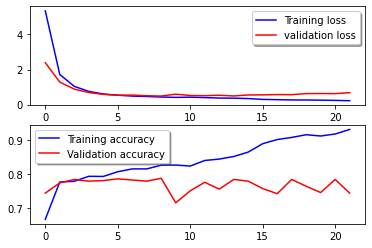

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

##**XGBoost for Classification**

In [ ]:
feature_extractor=base_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF

#RANDOM FOREST
#from sklearn.ensemble import RandomForestClassifier
#model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
y_train_label=np.where(y_train==1)[1]

#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train_label) #For sklearn no one hot encoding

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Accuracy =  0.7716666666666666


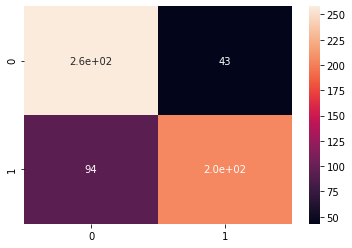

In [ ]:
import seaborn as sns
X_test_feature = base_model.predict(x_dev)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction = model.predict(X_test_features)
#Inverse le transform to get original label back. 
# prediction = le.inverse_transform(prediction)
y_test=np.where(y_dev==1)[1]
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [ ]:
pred=model.predict(X_test_features)

In [ ]:
# print("Loss of the model is - " , model.evaluate(X_test_features,y_test)[0])
# print("Accuracy of the model is - " , model.evaluate(X_test_features,y_test)[1]*100 , "%")
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       301
           1       0.83      0.69      0.75       299

    accuracy                           0.77       600
   macro avg       0.78      0.77      0.77       600
weighted avg       0.78      0.77      0.77       600



#**InceptionV3**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization,Dropout,MaxPooling2D
from tensorflow.keras.regularizers import l1,l2,l1_l2

base_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

#base_model = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
x=Conv2D(1024,(3,3),padding='same',activation='relu')(x)
x=GlobalAveragePooling2D()(x)
x=Flatten()(x)
x=Dense(1024,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x=Dropout(0.3)(x)
x=Dense(16,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x=Dense(2,activation='softmax')(x)
model=Model(base_model.input,x)


87916544/87910968 [==============================] - 1s 0us/step


##**Model Summary**

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
epochs = 100
batch_size = 20

##**Early Stopping**

In [ ]:
import keras

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=13,verbose=1,restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.22, patience = 6, verbose = 1, 
                                              min_delta = 0.0001,min_lr=0.0001)

In [ ]:
hist = model.fit(x_train,y_train,
                 epochs = epochs,
                validation_data = (x_dev,y_dev),
                callbacks = [early_stop,reduce_lr],
                verbose=1,shuffle=True)

Epoch 1/100
75/75 [==============================] - 18s 160ms/step - loss: 10.3163 - acc: 0.6797 - val_loss: 7.9752 - val_acc: 0.7517
Epoch 2/100
75/75 [==============================] - 9s 125ms/step - loss: 7.3145 - acc: 0.7376 - val_loss: 5.4761 - val_acc: 0.7667
Epoch 3/100
75/75 [==============================] - 9s 123ms/step - loss: 4.9951 - acc: 0.7477 - val_loss: 3.6650 - val_acc: 0.7667
Epoch 4/100
75/75 [==============================] - 9s 122ms/step - loss: 3.3123 - acc: 0.7783 - val_loss: 2.4490 - val_acc: 0.7600
Epoch 5/100
75/75 [==============================] - 9s 122ms/step - loss: 2.1998 - acc: 0.7714 - val_loss: 1.6942 - val_acc: 0.7467
Epoch 6/100
75/75 [==============================] - 9s 122ms/step - loss: 1.5341 - acc: 0.7674 - val_loss: 1.1978 - val_acc: 0.7767
Epoch 7/100
75/75 [==============================] - 9s 121ms/step - loss: 1.1073 - acc: 0.7796 - val_loss: 0.9498 - val_acc: 0.7733
Epoch 8/100
75/75 [==============================] - 9s 122ms/step 

##**Loss and accuracy plots for training and validation**

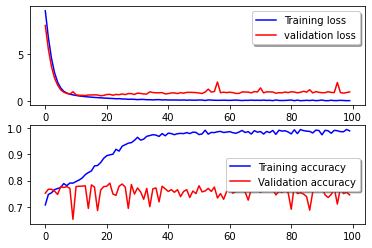

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['acc'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

##**XGBoost for Classification**

In [ ]:
feature_extractor=base_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF

# Train the model on training data
y_train_label=np.where(y_train==1)[1]

#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train_label) #For sklearn no one hot encoding

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Accuracy =  0.76


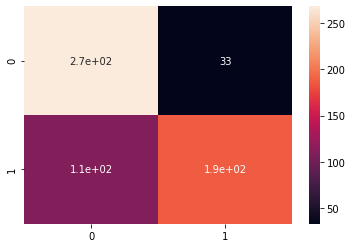

In [ ]:
import seaborn as sns
X_test_feature = base_model.predict(x_dev)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction = model.predict(X_test_features)
#Inverse le transform to get original label back. 
# prediction = le.inverse_transform(prediction)
y_test=np.where(y_dev==1)[1]
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [ ]:
pred=model.predict(X_test_features)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.71      0.89      0.79       301
           1       0.85      0.63      0.72       299

    accuracy                           0.76       600
   macro avg       0.78      0.76      0.76       600
weighted avg       0.78      0.76      0.76       600



In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, pred)
print("Accuracy: %.2f" % (accuracy))

Accuracy: 0.76
